In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
class option:
    
    def __init__(self, typ, strike, premium, grid=500):
        price = np.array(range(grid)) * 100
        self.pnl = pd.Series(np.zeros(grid)-premium, price)
        if typ == 'call':
            for i in range(grid):
                if i*100 > strike:
                    self.pnl[i*100] += i*100 - strike
        if typ == 'put':
            for i in range(grid):
                if i*100 < strike:
                    self.pnl[i*100] += strike - i*100

In [3]:
def laplace_1d(x, loc=0, scale=1):
    return scale / (2*np.exp(scale*abs(x-loc)))

def laplace_2d(x, loc=0, scale=1):
    return scale * (scale*abs(x-loc) + 1) / (4*np.exp(scale*abs(x-loc)))

def laplace_3d(x, loc=0, scale=1):
    return scale * ((scale*(x-loc))**2 + 3*scale*abs(x-loc) + 3) / (16*np.exp(scale*abs(x-loc)))

def normal_longterm(x, n, loc=0, scale=1):
    return ss.norm.pdf(x, loc, scale*np.sqrt(n))

def total_risk(w, metric='min_max_loss', central_strike=23000, n=24, loc=0.001937, scale=0.025625):
    
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    w4 = w[3]
    w5 = w[4]
    w6 = w[5]
    w7 = w[6]
    w8 = w[7]
    w9 = w[8]
    w10 = 1 - w.sum()
    
    p = w1 * call1.pnl + w3 * call2.pnl + w5 * call3.pnl + w7 * call4.pnl + w9 * call5.pnl
    p += w2 * put1.pnl + w4 * put2.pnl + w6 * put3.pnl + w8 * put4.pnl + w10 * put5.pnl
    
    if metric == 'min_max_loss':
        return -p.min()
    
    if metric == 'min_exp_loss':
        neg = p[p < 0]
        l = len(neg)
        s = 0
        for i in range(l):
            s += neg.values[i]
        return -s
    
    if metric == 'max_exp_return':
        s = 0
        step = (p.index[0] - central_strike) / central_strike - (p.index[1] - central_strike) / central_strike
        for i in range(len(p)):
            x = step = (p.index[i] - central_strike) / central_strike
            s += p.values[i] * normal_longterm(x,n,loc,scale)
        return -s

In [4]:
call = option('call', 23500, 80)
put = option('put', 22500, 80)

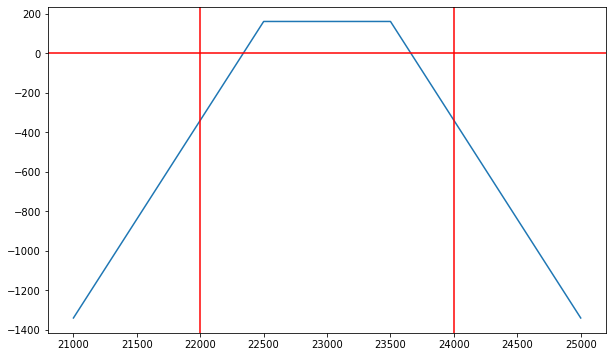

In [5]:
struct = -put.pnl-call.pnl
plt = struct[210:251].plot(figsize=(10,6))
plt.axhline(0, color='red')
plt.axvline(22000, color='red')
plt.axvline(24000, color='red')

In [6]:
call_premiums = [2970,2330,1770,1330,970]
put_premiums  = [890,1250,1690,2230,2870]

central_strike = 23000

call1 = option('call', central_strike-2000, call_premiums[0])
put1 = option('put', central_strike-2000, put_premiums[0])

call2 = option('call', central_strike-1000, call_premiums[1])
put2 = option('put', central_strike-1000, put_premiums[1])

call3 = option('call', central_strike, call_premiums[2])
put3 = option('put', central_strike, put_premiums[2])

call4 = option('call', central_strike+1000, call_premiums[3])
put4 = option('put', central_strike+1000, put_premiums[3])

call5 = option('call', central_strike+2000, call_premiums[4])
put5 = option('put', central_strike+2000, put_premiums[4])

In [7]:
x0 = np.array([1,-1,1,-1,1,-1,1,-1,1])*1/9#(np.zeros(9))*1/9
res = minimize(total_risk, x0, method='Nelder-Mead', tol=1e-6)
w = res.x
print(total_risk(w))

945.5944935017579


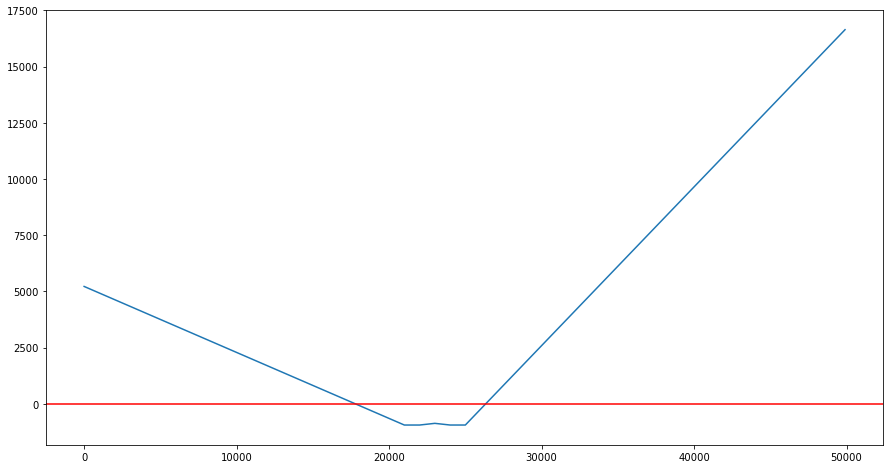

In [8]:
w1 = w[0]
w2 = w[1]
w3 = w[2]
w4 = w[3]
w5 = w[4]
w6 = w[5]
w7 = w[6]
w8 = w[7]
w9 = w[8]
w10 = 1 - w.sum()

p = w1 * call1.pnl + w3 * call2.pnl + w5 * call3.pnl + w7 * call4.pnl + w9 * call5.pnl
p += w2 * put1.pnl + w4 * put2.pnl + w6 * put3.pnl + w8 * put4.pnl + w10 * put5.pnl

plt = p.plot(figsize=(15,8))
plt.axhline(0, color='red')

In [9]:
w

array([ 0.2889632 ,  0.00464472,  0.1751438 , -0.10007566, -0.04049286,
       -0.10915746,  0.11508137, -0.04098515,  0.16769656])

### Изучение движения цены BTCUSD

In [8]:
btc = yf.download('BTC-USD')
btc_ret = btc['Close'].pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

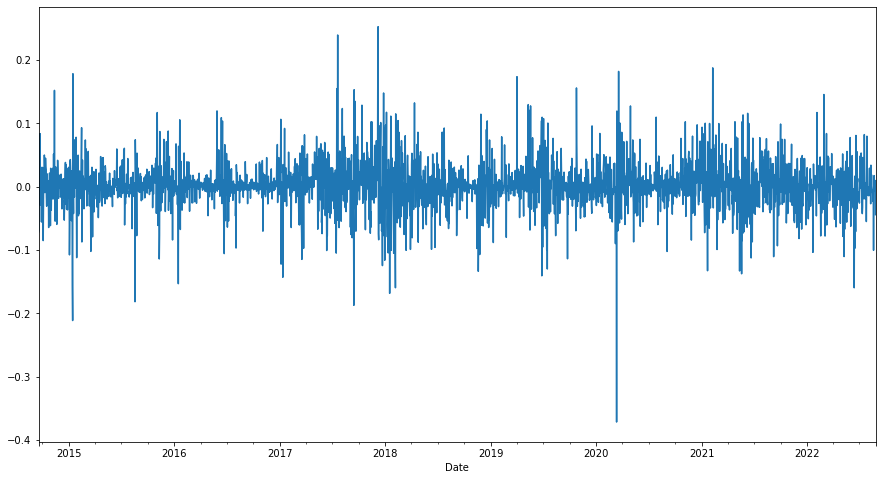

In [9]:
btc_ret.plot(figsize=(15,8))

Как видим, хорошо описывается распределением Лапласа:

In [10]:
params = ss.laplace.fit(btc_ret)

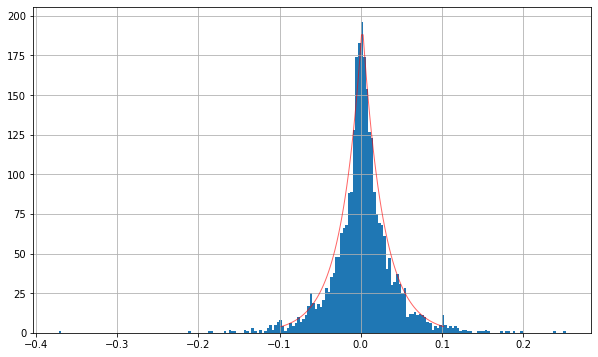

In [11]:
ax = btc_ret.hist(bins=200, figsize=(10,6))
x = np.linspace(ss.laplace.ppf(0.01,loc=params[0],scale=params[1]),
                ss.laplace.ppf(0.99,loc=params[0],scale=params[1]), 100)
ax.plot(x, 10*ss.laplace.pdf(x,loc=params[0],scale=params[1]),
       'r-', lw=1, alpha=0.6, label='laplace pdf')

In [14]:
x = np.linspace(-5,5,1001)

l1 = pd.Series(laplace_1d(x,0,1),x)
l2 = pd.Series(laplace_2d(x,0,1),x)
l3 = pd.Series(laplace_3d(x,0,1),x)
n = pd.Series(normal_longterm(x,24,0,1),x)

<AxesSubplot:>

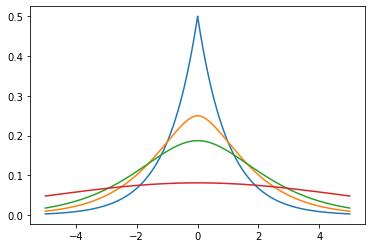

In [15]:
l1.plot()
l2.plot()
l3.plot()
n.plot()

Однако для приростов от месяца справедливо логнормальное распределение:

<AxesSubplot:>

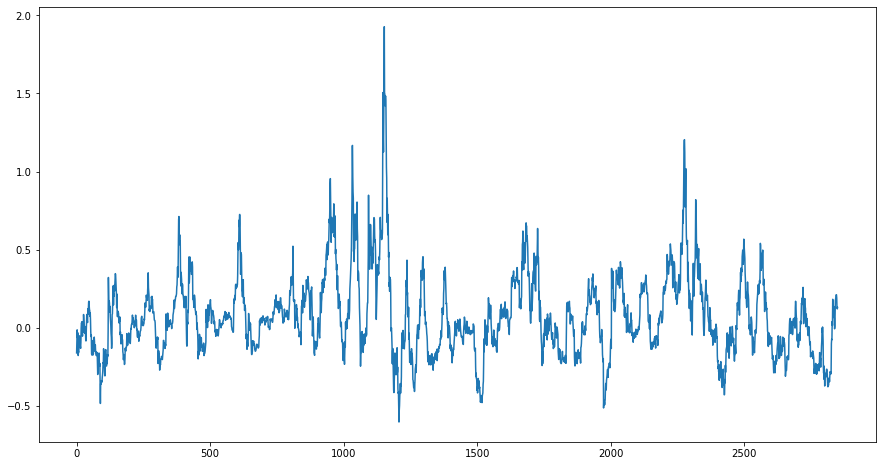

In [16]:
delta = 30

dp = np.zeros(len(btc)-delta)

for i in range(len(dp)):
    dp[i] = (btc['Close'].values[i+delta] - btc['Close'].values[i]) / btc['Close'].values[i]
dp = pd.Series(dp)

dp.plot(figsize=(15,8))

<AxesSubplot:>

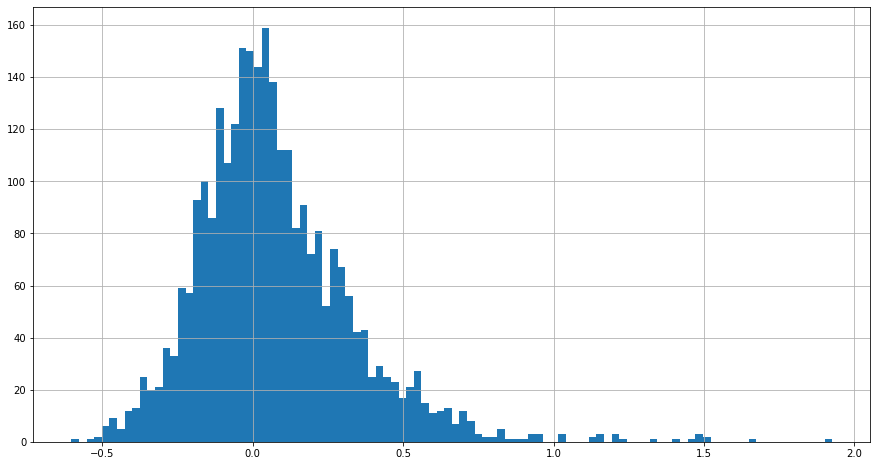

In [17]:
dp.hist(bins=100, figsize=(15,8))

### GARCH модель для BTCUSD

In [18]:
def GARCH(T, p, o, q, a, b, s):
    GARCH = pd.Series([0]*T)
    E = np.random.normal(loc=0, scale=s, size=T)
    S = pd.Series([o]*T)
    for i in range(1,T):
        for j in range (0, q):
            if(i > j):
                S[i:(i+1)] += b[j]*S[i-j-1]
        for j in range (0, q):
            if(i > j):
                S[i:(i+1)] += a[j]*E[i-j-1]
    for i in range(0,T):
        GARCH[i:(i+1)] += S[i]*E[i]
    return GARCH

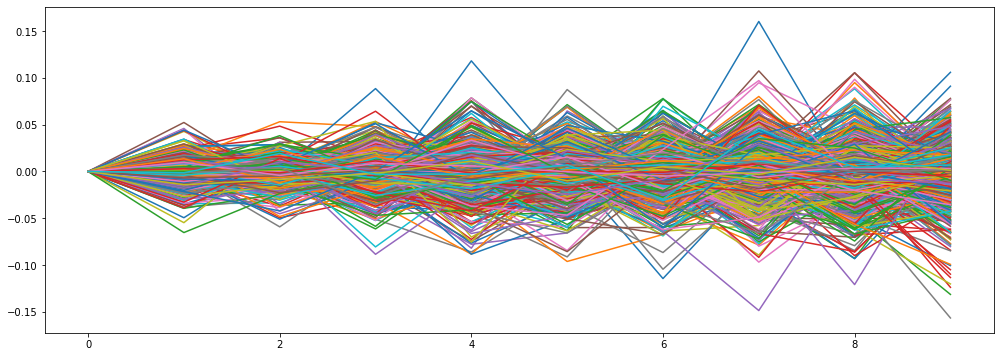

In [19]:
g = []
T = 10
n = 2000
for i in range(0,n):
    G = GARCH(T, 2, 0, 2, [0.9, 1.1], [-1.1, -0.9], 0.1)
    g.append(G[T-1])
    G.plot(figsize=(17,6))
g = pd.Series(g)

<AxesSubplot:>

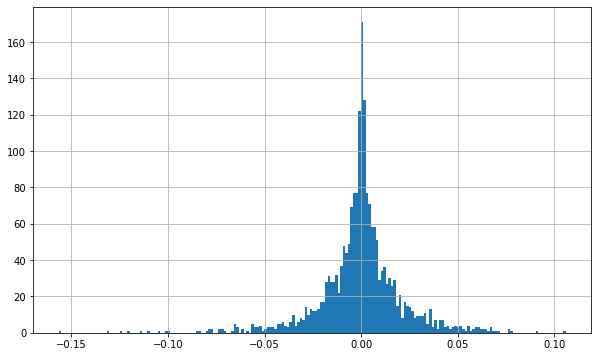

In [20]:
g.hist(bins=200, figsize=(10,6))

### Закрытые позиции

Короткий стрип на 4 августа с хеджирующим коллом:

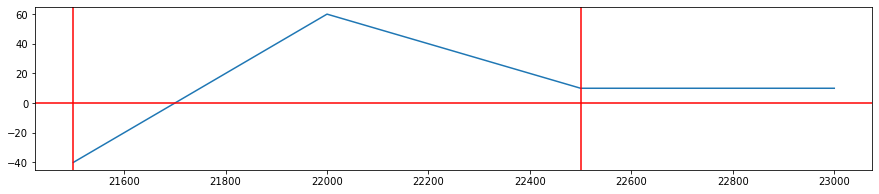

In [21]:
call1 = option('call', 22000, 1080)
call2 = option('call', 22500, 720)
call3 = option('call', 22500, 720)
call4 = option('call', 23000, 400)
put1 = option('put', 22000, 120)

struct = (-call1.pnl+call3.pnl-2*put1.pnl)*0.1
plt = struct[215:231].plot(figsize=(15,3))
plt.axhline(0, color='red')
plt.axvline(21500, color='red')
plt.axvline(22500, color='red')

Короткий стренгл на 5 августа:

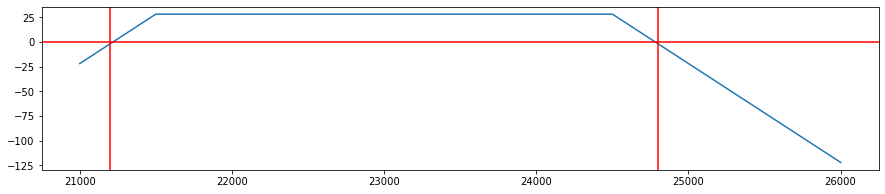

In [22]:
call = option('call', 21500, 1560)
put = option('put', 24500, 1720)
hedge_call = option('call', 24500, 160)
hedge_put = option('put', 22000, 100)

struct = (-put.pnl-call.pnl)*0.1
plt = struct[210:261].plot(figsize=(15,3))
plt.axhline(0, color='red')
plt.axvline(21200, color='red')
plt.axvline(24800, color='red')

### Открытая позиция

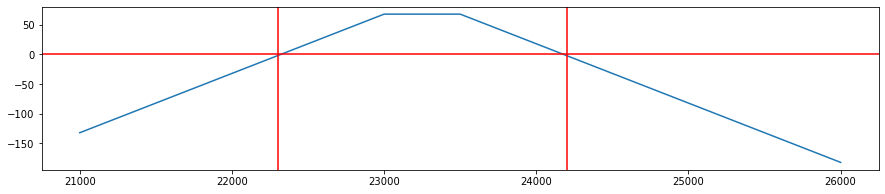

In [60]:
call = option('call', 23000, 460)
put = option('put', 23500, 540)
hedge_call = option('call', 23500, 120)
hedge_put = option('put', 23000, 200)

struct = (-put.pnl-call.pnl)*0.2 + (hedge_call.pnl + hedge_put.pnl)*0.1
plt = struct[210:261].plot(figsize=(15,3))
plt.axhline(0, color='red')
plt.axvline(22300, color='red')
plt.axvline(24200, color='red')

### Тест

Короткий стренгл на 12 августа:

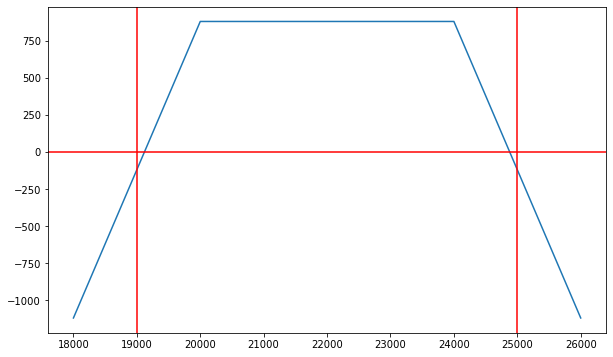

In [23]:
call = option('call', 24000, 600)
put = option('put', 20000, 280)
hedge_call = option('call', 24500, 140)
hedge_put = option('put', 21500, 200)

struct = -put.pnl-call.pnl#+hedge_call.pnl+hedge_put.pnl
plt = struct[180:261].plot(figsize=(10,6))
plt.axhline(0, color='red')
plt.axvline(19000, color='red')
plt.axvline(25000, color='red')

Длинный колл лэддер на 30 декабря:

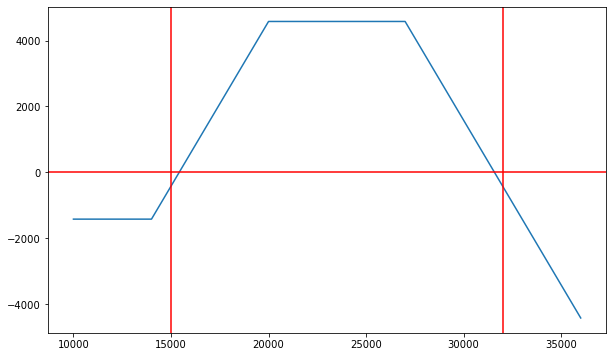

In [24]:
call = option('call', 27000, 2740)
put = option('put', 20000, 2760)
hedge_call = option('call', 32000, 1640)
hedge_put = option('put', 14000, 920)

struct = -put.pnl-call.pnl+hedge_put.pnl#+hedge_call.pnl
plt = struct[100:361].plot(figsize=(10,6))
plt.axhline(0, color='red')
plt.axvline(15000, color='red')
plt.axvline(32000, color='red')

Синтетический длинный форвард на 30 декабря:

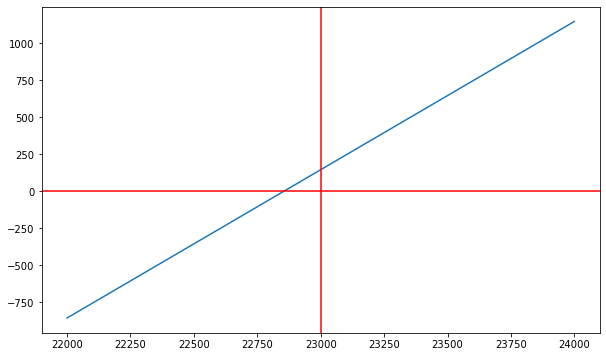

In [25]:
call = option('call', 22000, 2160)
put = option('put', 22000, 1305)
hedge_call = option('call', 32000, 1640)
hedge_put = option('put', 14000, 920)

struct = -put.pnl+call.pnl#+hedge_put.pnl#+hedge_call.pnl
plt = struct[220:241].plot(figsize=(10,6))
plt.axhline(0, color='red')
plt.axvline(23000, color='red')
#plt.axvline(32000, color='red')

Продажа покрытого колла на 4 августа:

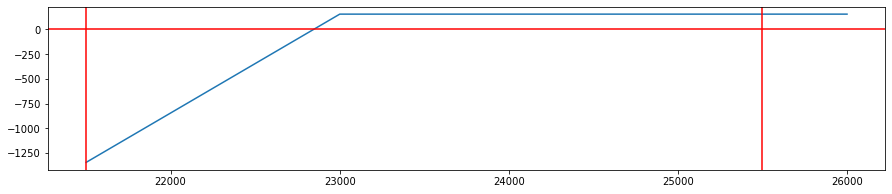

In [26]:
call1 = option('call', 23000, 560)
call2 = option('call', 23405, 0)
put1 = option('put', 23405, 0)

struct = -call1.pnl+call2.pnl-put1.pnl
plt = struct[215:261].plot(figsize=(15,3))
plt.axhline(0, color='red')
plt.axvline(21500, color='red')
plt.axvline(25500, color='red')

Короткий стренгл на 12 августа:

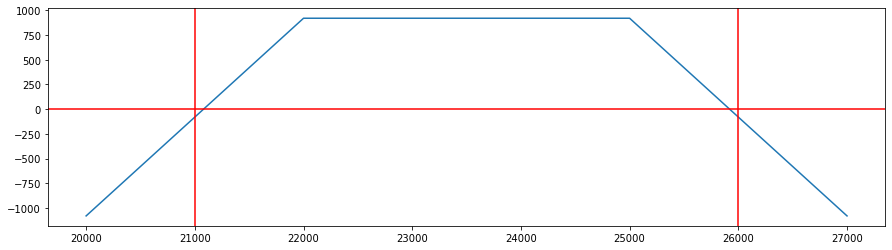

In [27]:
call = option('call', 25000, 440)
put = option('put', 22000, 480)
hedge_call = option('call', 24500, 600)
hedge_put = option('put', 22500, 655)

struct = -put.pnl-call.pnl#+hedge_put.pnl+hedge_call.pnl
plt = struct[200:271].plot(figsize=(15,4))
plt.axhline(0, color='red')
plt.axvline(21000, color='red')
plt.axvline(26000, color='red')

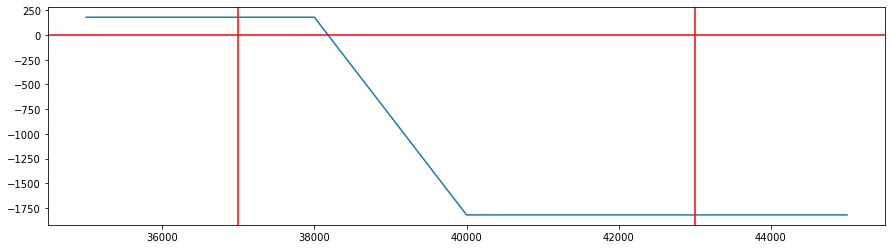

In [28]:
call = option('call', 25000, 10)
put = option('put', 38000, 15460)
hedge_call = option('call', 24500, 600)
hedge_put = option('put', 40000, 17280)

struct = -put.pnl+hedge_put.pnl#-call.pnl#+hedge_call.pnl
plt = struct[350:451].plot(figsize=(15,4))
plt.axhline(0, color='red')
plt.axvline(37000, color='red')
plt.axvline(43000, color='red')

Бокс на 12 августа (не работает из-за большого спреда):

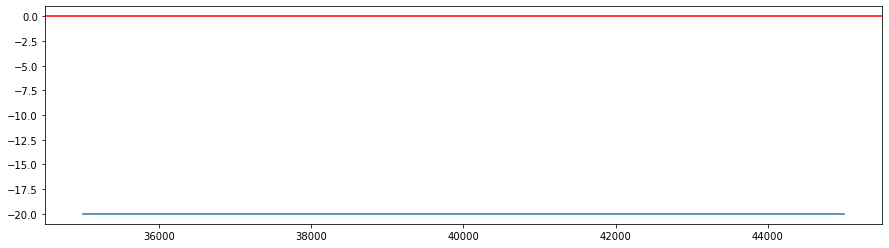

In [29]:
call = option('call', 24000, 760)
put = option('put', 23000, 780)
hedge_call = option('call', 23000, 1260)
hedge_put = option('put', 24000, 1300)

struct = -put.pnl+hedge_put.pnl-call.pnl+hedge_call.pnl
plt = struct[350:451].plot(figsize=(15,4))
plt.axhline(0, color='red')
#plt.axvline(37000, color='red')
#plt.axvline(43000, color='red')

Короткий стреддл на 6 августа с хеджем:

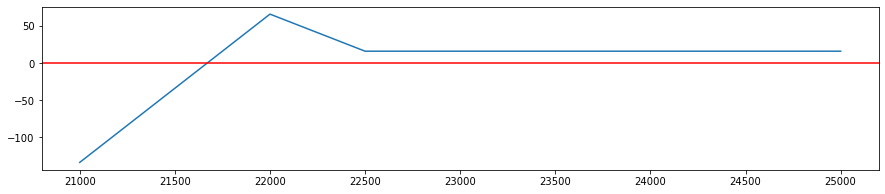

In [30]:
call1 = option('call', 22000, 780)
call2 = option('call', 22500, 480)
put1 = option('put', 22000, 180)

struct = (-call1.pnl+call2.pnl-2*put1.pnl)*0.1
plt = struct[210:251].plot(figsize=(15,3))
plt.axhline(0, color='red')
#plt.axvline(21200, color='red')
#plt.axvline(24800, color='red')

Короткий стренгл на 6 августа:

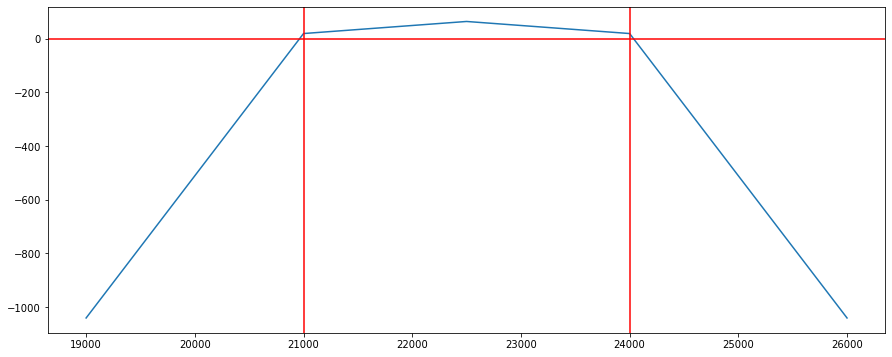

In [31]:
call = option('call', 22500, 480)
put = option('put', 22500, 340)
hedge_call = option('call', 24000, 40)
hedge_put = option('put', 21000, 40)

struct = -0.03*put.pnl-0.03*call.pnl-0.5*hedge_put.pnl-0.5*hedge_call.pnl
plt = struct[190:261].plot(figsize=(15,6))
plt.axhline(0, color='red')
plt.axvline(21000, color='red')
plt.axvline(24000, color='red')

### Подбор весов

In [32]:
call_premiums = np.array([410, 30])
put_premiums = np.array([90, 710])

call_strikes = np.array([23000, 24000])
put_strikes = np.array([23000, 24000])

g = 500

def pnl(typ, strike, premium, grid=g):
    price = np.array(range(grid)) * 100
    res = pd.Series(np.zeros(grid)-premium, price)
    if typ == 'call':
        for i in range(grid):
            if i*100 > strike:
                res[i*100] += i*100 - strike
    if typ == 'put':
        for i in range(grid):
            if i*100 < strike:
                res[i*100] += strike - i*100
    return res

def position_risk(w, plot=False, n=2, grid=g):
    p = pd.Series(np.zeros(grid))
    p.index *= 100
    w_nn = 2*n - np.sum(abs(w))
    for i in range(n-1):
        p += pnl('call', call_strikes[i], call_premiums[i]) * w[i] - 10
        p += pnl('put', put_strikes[i], put_premiums[i]) * w[i+n] - 10
    p += pnl('call', call_strikes[n-1], call_premiums[n-1]) * w[n-1] - 10
    p += pnl('put', put_strikes[n-1], put_premiums[n-1]) * w_nn - 10
    if plot:
        plt = p.plot(figsize=(15,5))
        plt.axhline(0, color='red')
    neg = -1 * p[p <= 0]
    return neg.max()

In [33]:
x0 = np.array([1,1,1])
res = minimize(position_risk, x0, method='Nelder-Mead', tol=1e-6)
w = res.x
print(position_risk(w))

159.5546602847357


159.5546602847357

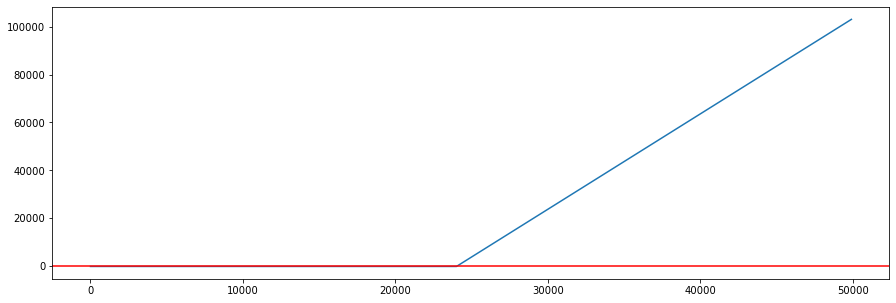

In [34]:
position_risk(w,True)